# Imports

In [1]:
import os
import emoji
from collections import Counter
import pandas as pd
import seaborn as sns
import math
import numpy as np
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100) 

2024-07-16 23:19:36.920658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read Data

In [2]:
ch_sample_link = '/data/ch_sample_selections_data.csv'
cg_sample_link = '/data/sample_wsb_gme_personalfin_stock.csv'
rr_sample_link = '/data/forex_finance_finindependence_forex.csv'

file_links = [ch_sample_link, cg_sample_link, rr_sample_link]

In [3]:
ch_sample = pd.read_csv(os.getcwd() + ch_sample_link)
cg_sample = pd.read_csv(os.getcwd() + cg_sample_link)
rr_sample = pd.read_csv(os.getcwd() + rr_sample_link)

In [4]:
print(ch_sample.shape, cg_sample.shape, rr_sample.shape)

(15000, 25) (16000, 25) (6104, 25)


In [5]:
# datatypes match
pd.concat([ch_sample.dtypes,cg_sample.dtypes,rr_sample.dtypes],axis=1)

,0,1,2
Unnamed: 0,int64,int64,int64
id,object,object,object
author,object,object,object
created,object,object,object
retrieved,object,object,object
edited,object,object,object
pinned,int64,int64,int64
archived,int64,int64,int64
locked,int64,int64,int64
removed,int64,int64,int64


In [6]:
def read_files(file_links):
    df = pd.DataFrame()
    for link in file_links:
        df = pd.concat((df, pd.read_csv(os.getcwd() + link)), axis=0)
    return df

In [7]:
df = read_files(file_links)

# Examine Data

In [8]:
df.shape

(37104, 25)

In [9]:
df.isna().sum()

Unnamed: 0                  0
id                          0
author                      0
created                     0
retrieved                   0
edited                      0
pinned                      0
archived                    0
locked                      0
removed                     0
deleted                     0
is_self                     0
is_video                    0
is_original_content         0
title                       0
link_flair_text          9082
upvote_ratio                0
score                       0
gilded                      0
total_awards_received       0
num_comments                0
num_crossposts              0
selftext                    1
thumbnail                   0
shortlink                   0
dtype: int64

In [10]:
# We will drop null selftext
print(df.shape)
df = df.dropna(subset='selftext')
print(df.shape)


(37104, 25)
(37103, 25)


In [11]:
# Will fill NA's for link_flair_text.
df[df['link_flair_text'].isna()].fillna({'link_flair_text':''}).iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
10000,0,l6xblc,MasterCookSwag,2021-01-28 14:01:41,2021-02-04 22:50:10,1970-01-01 00:00:00,0,0,0,0,...,,0.91,62,0,0,25,0,"Hi All, \n\nSo far most of the threads in the modqueue are just people asking about GME, shortin...",self,https://redd.it/l6xblc
10001,1,nv41o6,jammerjoint,2021-06-08 13:29:37,2021-06-15 14:37:31,2021-06-08 14:47:24,0,0,0,0,...,,0.86,60,0,2,42,0,From a brief search it’s been a while since anyone posted on this subject or covered it in a sat...,self,https://redd.it/nv41o6


In [12]:
df.describe()

,Unnamed: 0,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
count,37103.000000,37103.0,37103.0,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000
mean,62921.779964,0.0,0.0,0.001348,0.017573,0.014878,0.985122,0.000108,0.003046,0.777643,93.128103,0.023664,0.761475,67.770612,0.068485
std,133301.310910,0.0,0.0,0.036685,0.131394,0.121064,0.121064,0.010383,0.055103,0.198820,1194.726751,0.608309,8.956003,1055.384714,0.520844
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2136.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.670000,1.000000,0.000000,0.000000,3.000000,0.000000
50%,4349.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.820000,5.000000,0.000000,0.000000,8.000000,0.000000
75%,63041.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.950000,18.000000,0.000000,0.000000,21.000000,0.000000
max,774958.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,138766.000000,108.000000,661.000000,95717.000000,48.000000


Remove the "Unnamed: 0" field

In [13]:
df.iloc[:5]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,0,kx6ej5,afengine,2021-01-14 14:14:53,2021-02-03 21:13:34,1970-01-01 00:00:00,0,0,0,0,...,Catalyst,1.00,10,0,0,6,0,Has anyone been buying $NEOV? They make a lithium iron (not ion) home batterys for power outages...,self,https://redd.it/kx6ej5
1,1,lgxcj2,Ninjakilla_X,2021-02-10 16:28:37,2021-02-11 04:48:49,1970-01-01 00:00:00,0,0,0,0,...,Stock Info :stonk:,0.88,12,0,0,16,0,"Feb. 09, 2021 (GLOBE NEWSWIRE) -- Staffing 360 Solutions, Inc. (NASDAQ: STAF), a staffing compan...",self,https://redd.it/lgxcj2
2,2,pbds23,fustreiche,2021-08-25 15:38:44,2021-08-26 00:28:31,1970-01-01 00:00:00,0,0,0,0,...,OTC :OTC:,1.00,1,0,0,1,0,"$MAPT On News : \n\nMaptelligent, Inc. (OTC PK: MAPT) www.maptelligent.com:\n\nFurthering its d...",self,https://redd.it/pbds23
3,3,lqyq3v,kaizenn7,2021-02-24 00:50:38,2021-02-24 13:03:20,2021-02-24 01:04:01,0,0,0,0,...,DD :DD:,0.87,22,0,0,7,0,"# Summary\n\n* T2 has been a huge beneficiary of the COVID-19 pandemic, as hospitals take a seco...",https://b.thumbs.redditmedia.com/9nU8klZqaMJQ9bVnIdrKmH2ecxAifWDJxIyYgDvWy8g.jpg,https://redd.it/lqyq3v
4,4,ld60v9,eayaz,2021-02-05 12:20:38,2021-02-05 15:51:17,2021-02-05 13:30:21,0,0,0,0,...,Question :Question:,0.98,1177,0,18,517,0,"Hey everybody,\n\nLike a lot of you I browse Reddit and Twitter and use them as “scanner” tools ...",self,https://redd.it/ld60v9


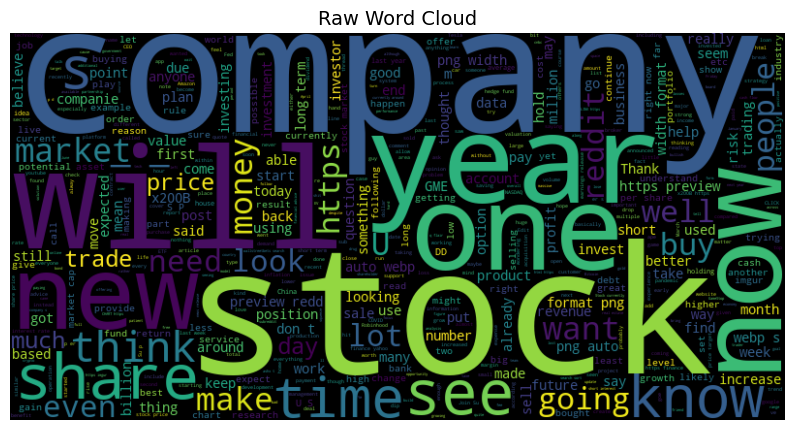

In [14]:
plt.figure(figsize=(10, 10))
words = " ".join(df['selftext'])
wc1 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc1, interpolation='bilinear')
plt.title('Raw Word Cloud', fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

In [15]:
search_terms = [r'https', r'webp','png']

In [16]:
# The search terms are all part of url's. They will be removed.
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].iloc[2][:1000]

'# Summary\n\n* T2 has been a huge beneficiary of the COVID-19 pandemic, as hospitals take a second look at its revolutionary diagnostic technology.\n* A 300% revenue gain is projected by Wall Street for 2021 vs. 2019.\n* Lower cash burn, potentially turning into cash flow from rising sales, may support a major equity quote advance the next 12-18 months.\n\n[T2 Biosystems](https://www.t2biosystems.com/products-technology/t2bacteria-panel/) ([TTOO](https://t2biosystems.gcs-web.com/static-files/3b28bb08-163f-4bb6-8a63-74696329d8ff?source=content_type%3Areact%7Cfirst_level_url%3Aarticle%7Csection%3Amain_content%7Cbutton%3Abody_link)) is a minor diagnostics company, quickly reinventing its balance sheet and growth prospects on the back of the COVID-19 pandemic. Its revolutionary testing system has been around for many years without significant success, because of a high upfront machine cost for  hospitals and clinics, and industry acceptance of slower testing protocols. Including the equip

In [17]:
df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).iloc[0]

'Has anyone been buying $NEOV? They make a lithium iron (not ion) home batterys for power outages/solar and seem to be getting more and more sales, and are primed up for being competitive for green energy money that is sure to be a part of Bidens stimulus.  The CEO is a retired marine and they just appointed a former chairman of the joint chiefs of staff, James Amos to their board of directors. I am sure he will help navigate the company to set itself up for contracts.\n\n&#x200B;\n\n[<url>)'

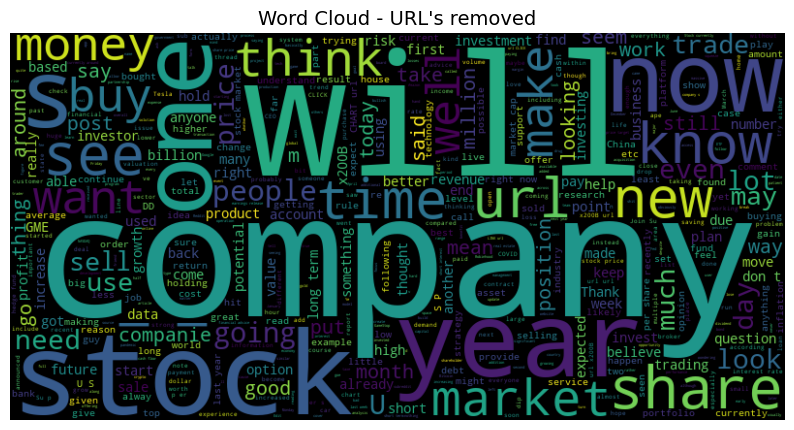

In [18]:
# Replace the HTTPS with <url>
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's removed", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

In [19]:
# Identifying x200b, which is zero width space
search_terms = ['x200']
zero_width_indexes = df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))
df[zero_width_indexes]['selftext'].iloc[0]

'Has anyone been buying $NEOV? They make a lithium iron (not ion) home batterys for power outages/solar and seem to be getting more and more sales, and are primed up for being competitive for green energy money that is sure to be a part of Bidens stimulus.  The CEO is a retired marine and they just appointed a former chairman of the joint chiefs of staff, James Amos to their board of directors. I am sure he will help navigate the company to set itself up for contracts.\n\n&#x200B;\n\n[https://www.neovolta.com/general-james-f-amos-usmc-ret-former-chairman-of-lord-corp-joins-neovolta-board-of-directors/](https://www.neovolta.com/general-james-f-amos-usmc-ret-former-chairman-of-lord-corp-joins-neovolta-board-of-directors/)'

In [20]:
# Remove zero width spaces (x200B)
df[zero_width_indexes]['selftext'].apply(lambda x: re.sub(r'x200B', '', x)).iloc[0]

'Has anyone been buying $NEOV? They make a lithium iron (not ion) home batterys for power outages/solar and seem to be getting more and more sales, and are primed up for being competitive for green energy money that is sure to be a part of Bidens stimulus.  The CEO is a retired marine and they just appointed a former chairman of the joint chiefs of staff, James Amos to their board of directors. I am sure he will help navigate the company to set itself up for contracts.\n\n&#;\n\n[https://www.neovolta.com/general-james-f-amos-usmc-ret-former-chairman-of-lord-corp-joins-neovolta-board-of-directors/](https://www.neovolta.com/general-james-f-amos-usmc-ret-former-chairman-of-lord-corp-joins-neovolta-board-of-directors/)'

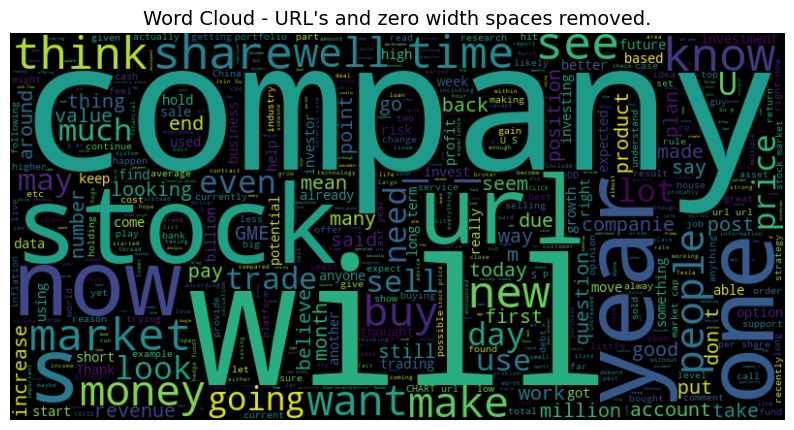

In [21]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).apply(lambda x: re.sub(r'x200B', '', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's and zero width spaces removed.", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

What are common selftext values, and how should they be handled?

In [22]:
df['selftext'].value_counts().iloc[:5]

selftext
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [23]:
# "deleted" self_text should be deleted
df.shape, df[df['selftext']!='[deleted]'].shape

((37103, 25), (36551, 25))

In [24]:
text_frequency = df['selftext'].value_counts().reset_index()
text_frequency = text_frequency[text_frequency['count']>3]
discussion_posts = text_frequency['selftext'].tolist()
df[df['selftext'].isin(discussion_posts)].iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
35,35,mah70h,PennyBotWeekly,2021-03-22 06:55:19,2021-03-22 13:04:21,1970-01-01 00:00:00,0,0,0,0,...,Megathread,0.91,18,0,0,120,0,\n\nTalk about your plays today or things you are on the lookout for. This is where you belong ...,self,https://redd.it/mah70h
66,66,pafb97,PennyBotWeekly,2021-08-24 03:25:19,2021-08-24 10:17:42,1970-01-01 00:00:00,0,0,0,0,...,Megathread,1.00,3,0,0,9,0,THE LOUNGE and DAILY PLAYS Megathreads are now integrated into a single Megathread!!!!!\n\nIn an...,self,https://redd.it/pafb97


# Cleaning Data

### Drop NA's

In [25]:
df = df.dropna(subset='selftext')

### Fill NA's

In [26]:
df = df.fillna({'link_flair_text':''})

### Remove [deleted] selftext entries

In [27]:
df = df[df['selftext']!='[deleted]']

### Remove discussion posts

In [28]:
def remove_discussion_posts(df_orig):
    '''Discussion posts are defined as posts that occur more than 3 times.'''
    df = df_orig.copy()

    text_frequency = df['selftext'].value_counts().reset_index()
    text_frequency = text_frequency[text_frequency['count']>3]
    discussion_posts = text_frequency['selftext'].tolist()
    
    df = df[~df['selftext'].isin(discussion_posts)]


    return df

# df = remove_discussion_posts(df)

### Preprocess data and clean data
We must remove excess HTML and other words.

In [29]:
unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
df = df.drop(columns=unnamed_columns)

We must remove excess HTML and other words.

In [30]:
def preprocessor(text):
    try:
        text = re.sub('<[^>]*>', '', text)
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                               text)
        text = (re.sub('[\W]+', ' ', text.lower()) +
                ' '.join(emoticons).replace('-', ''))
    except Exception as e:
        print(f'Exception when preprocessing.\n{e}')
    finally:
        return text

# from https://stackoverflow.com/questions/70304914/sentiment-analysis-python-tokenization
def cleaner(text):
    text = str(text).lower()
    text = re.sub(r'#(\w+)', r'<\1>', text)
    text = re.sub(r'\n', ' ', text) # Remove /n
    text = re.sub(r'@[A-Za-z0-9]+', '<user>', text) # Remove and replace @mention
    text = re.sub(r'RT\s+', '', text) # Remove RT
    text = re.sub(r'https?://\S+\b/?', '<url>', text) # Remove and replace links
    text = re.sub('x200B', '', text)
    return text

# There's a chance we WON'T need to convert emojis to text if the model we're using supports emojis, but this might be useful
def deemoji_text(text):
    return emoji_demojize(text)

def deemoji_text_unicode(text):
    return text.encode('unicode-escape').decode('utf-8')

def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+')
    return url_pattern.sub('', text)

In [31]:
df['selftext'] = df['selftext'].apply(cleaner).apply(preprocessor)

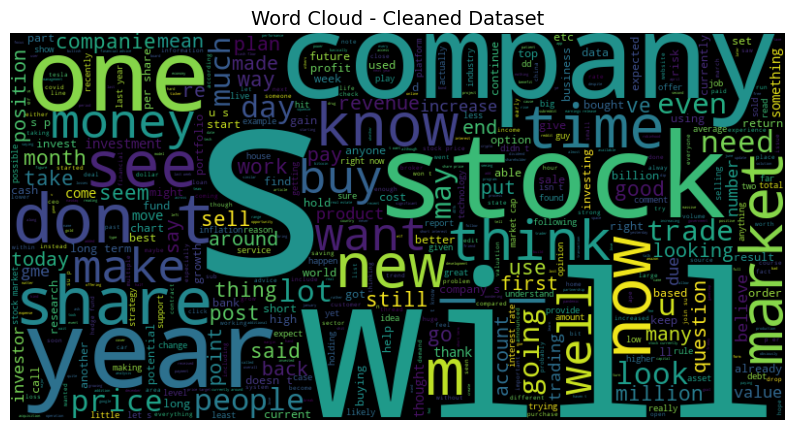

In [51]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'] )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - Cleaned Dataset", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

# Standardizing Numeric Fields

In [33]:
#Examine Numeric Fields
numeric_columns = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.values
df[numeric_columns]

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
0,0,0,0,0,0,1,0,0,1.00,10,0,0,6,0
1,0,0,0,0,0,1,0,0,0.88,12,0,0,16,0
2,0,0,0,0,0,1,0,0,1.00,1,0,0,1,0
3,0,0,0,0,0,1,0,0,0.87,22,0,0,7,0
4,0,0,0,0,0,1,0,0,0.98,1177,0,18,517,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,0,0,0,0,0,1,0,0,1.00,1,0,0,2,0
6076,0,0,0,0,0,1,0,0,0.67,1,0,0,3,0
6085,0,0,0,0,0,1,0,0,1.00,2,0,0,2,0
6095,0,0,0,0,0,1,0,0,1.00,1,0,0,1,0


In [34]:
((df['gilded'] - df['gilded'].mean()) / df['gilded'].std()).iloc[:3]

0   -0.039194
1   -0.039194
2   -0.039194
Name: gilded, dtype: float64

In [35]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts']
non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

In [36]:
scaler = StandardScaler()

df_scaled_values = scaler.fit_transform(df[scaling_fields].values)

df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)

In [37]:
print(df_scaled.columns)
scaling_fields_std = [f'{i}_std' for i in df_scaled.columns]
df_scaled.columns = scaling_fields_std
print(df_scaled.columns)

Index(['upvote_ratio', 'score', 'gilded', 'total_awards_received',
       'num_comments', 'num_crossposts'],
      dtype='object')
Index(['upvote_ratio_std', 'score_std', 'gilded_std',
       'total_awards_received_std', 'num_comments_std', 'num_crossposts_std'],
      dtype='object')


In [38]:
df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)

In [39]:
df_std.iloc[0]

id                                                                                                                        kx6ej5
author                                                                                                                  afengine
created                                                                                                      2021-01-14 14:14:53
retrieved                                                                                                    2021-02-03 21:13:34
edited                                                                                                       1970-01-01 00:00:00
pinned                                                                                                                         0
archived                                                                                                                       0
locked                                                                                           

# Split Data into training, validation, and test segments.

In [48]:
df_std.iloc[:1]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,title,link_flair_text,selftext,thumbnail,shortlink,upvote_ratio_std,gilded_std,total_awards_received_std,num_comments_std,num_crossposts_std
0,kx6ej5,afengine,2021-01-14 14:14:53,2021-02-03 21:13:34,1970-01-01 00:00:00,0,0,0,0,0,...,"$NEOV - Neovolta, a California based Home Battery Company",Catalyst,has anyone been buying neov they make a lithium iron not ion home batterys for power outages sol...,self,https://redd.it/kx6ej5,1.132776,-0.039195,-0.085666,-0.059037,-0.132404


In [41]:
df_std_y = df_std['score_std']
df_std = df_std.drop(columns='score_std')

In [49]:
df_std_y.iloc[:1]

0   -0.070163
Name: score_std, dtype: float64

In [50]:
df_std.iloc[:1]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,title,link_flair_text,selftext,thumbnail,shortlink,upvote_ratio_std,gilded_std,total_awards_received_std,num_comments_std,num_crossposts_std
0,kx6ej5,afengine,2021-01-14 14:14:53,2021-02-03 21:13:34,1970-01-01 00:00:00,0,0,0,0,0,...,"$NEOV - Neovolta, a California based Home Battery Company",Catalyst,has anyone been buying neov they make a lithium iron not ion home batterys for power outages sol...,self,https://redd.it/kx6ej5,1.132776,-0.039195,-0.085666,-0.059037,-0.132404


In [44]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(df_std, df_std_y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, train_size=0.75)

In [45]:
X_train.shape[0] / df_std.shape[0]

0.5999835845804492

In [46]:
# X_train.to_csv('./data/reddit_data_cleaned_X_TRAIN.csv')
# y_train.to_csv('./data/reddit_data_cleaned_Y_TRAIN.csv')

# X_val.to_csv('./data/reddit_data_cleaned_X_VAL.csv')
# y_val.to_csv('./data/reddit_data_cleaned_Y_VAL.csv')

# X_test.to_csv('./data/reddit_data_cleaned_X_TEST.csv')
# y_test.to_csv('./data/reddit_data_cleanedY_TEST.csv')